<a href="https://colab.research.google.com/github/parmida-pzshk/ISP_OncoDAM/blob/main/Using_MedSAM_to_segment_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#Download the file which is publicly available on Google Drive
import gdown
import os
import zipfile
# Define the file ID and URL
file_id = "1eez9FoI0VXyfYyBEe9Vp0xNYD9zESV-P"
url = f"https://drive.google.com/uc?id={file_id}"

# Define the output file name
output = "mydata.zip"

# Download the file
gdown.download(url, output, quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=1eez9FoI0VXyfYyBEe9Vp0xNYD9zESV-P
From (redirected): https://drive.google.com/uc?id=1eez9FoI0VXyfYyBEe9Vp0xNYD9zESV-P&confirm=t&uuid=02e5d89a-ea14-4dd2-b11a-b4df8877ecc5
To: /content/mydata.zip
100%|██████████| 5.31G/5.31G [00:40<00:00, 133MB/s]


'mydata.zip'

In [ ]:
# Define the extraction path
extract_to_path = "content/"
os.makedirs(extract_to_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("The zip file has been extracted successfully.")

The zip file has been extracted successfully.


In this version of the file, MedSAM has been used to generate masks for normal tissue images, as they didn't have any ground truth masks provided by the authors. However, both segmented and unsegmented versions of the images are saved and you can run the model with either of them.

In [ ]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━

In [ ]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [ ]:
# Paths /content/content/mydata/tissue-train-neg/testing
# tumor_test_dir = "/content/content/mydata/tissue-train-pos-v1/testing"
# normal_test_dir = "/content/content/mydata/tissue-train-neg/testing"
# tumor_masks_test_dir = "/content/content/mydata/tissue-train-pos-v1/testing_masks"
# normal_masks_test_dir = "/content/content/mydata/tissue-train-neg/testing_masks"
normal_training_dir = "/content/content/content/mydata/tissue-train-neg/training/unmasked"
normal_masks_training_dir = "/content/content/content/mydata/tissue-train-neg/training_masks"
# Create output directories if they don't exist
# os.makedirs(tumor_masks_test_dir, exist_ok=True)
# os.makedirs(normal_masks_test_dir, exist_ok=True)
os.makedirs(normal_masks_training_dir, exist_ok=True)

In [ ]:
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2025-03-01 11:10:30--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================>] 357.67M  17.6MB/s    in 23s     

2025-03-01 11:10:54 (15.4 MB/s) - ‘medsam_vit_b.pth’ saved [375049145/375049145]



In [ ]:
import os
import numpy as np
import torch
import cv2
import skimage.io as io
import skimage.transform as transform
from tqdm import tqdm
from PIL import Image
import gc
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [ ]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()


def segment_and_save(input_dir, masks_output_dir):
    """Processes images, applies segmentation, and saves masks."""
    image_filenames = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for filename in tqdm(image_filenames, desc=f"Processing {input_dir}"):
        image_path = os.path.join(input_dir, filename)
        img_np = io.imread(image_path)

        # Ensure image is in RGB format
        if len(img_np.shape) == 2:  # Grayscale to RGB
            img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
        else:
            img_3c = img_np

        H, W, _ = img_3c.shape

        # Preprocess image (resize and normalize)
        img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
        img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)
        img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

        # Define bounding box (whole image)
        box_np = np.array([[0, 0, W, H]])
        box_1024 = box_np / np.array([W, H, W, H]) * 1024

        # Run MedSAM segmentation
        with torch.no_grad():
            image_embedding = medsam_model.image_encoder(img_1024_tensor)

        binary_mask = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

        # Save mask as an image
        mask_save_path = os.path.join(masks_output_dir, filename)
        cv2.imwrite(mask_save_path, (binary_mask * 255).astype(np.uint8))
                # **Free GPU memory**
        del img_1024_tensor, image_embedding, binary_mask
        torch.cuda.empty_cache()
        gc.collect()  # Free Python memory



# Process both tumor and normal images
#segment_and_save(tumor_test_dir, tumor_masks_test_dir)
segment_and_save(normal_training_dir, normal_masks_training_dir)

print("✅ All images processed. Masks saved successfully.")



Processing /content/content/content/mydata/tissue-train-neg/training/unmasked: 100%|██████████| 328/328 [1:09:44<00:00, 12.76s/it]

✅ All images processed. Masks saved successfully.


In [ ]:
import os
import cv2
import numpy as np
import gc
from tqdm import tqdm



normal_training_dir = "/content/content/content/mydata/tissue-train-neg/training/unmasked"
normal_masks_training_dir = "/content/content/content/mydata/tissue-train-neg/training_masks"
normal_masked_training_dir = "/content/content/content/mydata/tissue-train-neg/training_masked"

# Create output directories if they don't exist
# os.makedirs(tumor_masked_test_dir, exist_ok=True)
os.makedirs(normal_masked_training_dir, exist_ok=True)

def apply_mask(image_path, mask_path, save_path, dim_factor=0.3):
    """Applies the mask to dim non-tumor areas without removing them."""
    try:
        img = cv2.imread(image_path)  # Use cv2.IMREAD_REDUCED_COLOR_2 if needed
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"⚠️ Skipping {image_path} (missing image/mask)")
            return

        # Resize mask to match the image size
        if mask.shape[:2] != img.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Convert mask to binary
        _, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        binary_mask = binary_mask.astype(np.float32) / 255.0  # Normalize to 0-1 range

        # Apply mask: Keep tumor regions, dim non-tumor regions

        dim_factor = 0.3
        masked_img = (img * binary_mask[..., np.newaxis]) + (img * dim_factor * (1 - binary_mask[..., np.newaxis]))
        masked_img = masked_img.astype(np.uint8)

        # Save the masked image
        cv2.imwrite(save_path, masked_img)

        # Free memory
        del img, mask, binary_mask, masked_img
        gc.collect()

    except Exception as e:
        print(f"⚠️ Error processing {image_path}: {e}")

# Process images one by one
for img in tqdm(os.listdir(normal_training_dir), desc="Applying masks"):
    img_path = os.path.join(normal_training_dir, img)
    mask_path = os.path.join(normal_masks_training_dir, img)  # Find corresponding mask
    save_path = os.path.join(normal_masked_training_dir, img)

    apply_mask(img_path, mask_path, save_path)

    # Clear GPU memory if using Colab
    gc.collect()

print(f"✅ Masked images saved in {normal_masked_training_dir}")


Applying masks: 100%|██████████| 328/328 [09:00<00:00,  1.65s/it]

✅ Masked images saved in /content/content/content/mydata/tissue-train-neg/training_masked


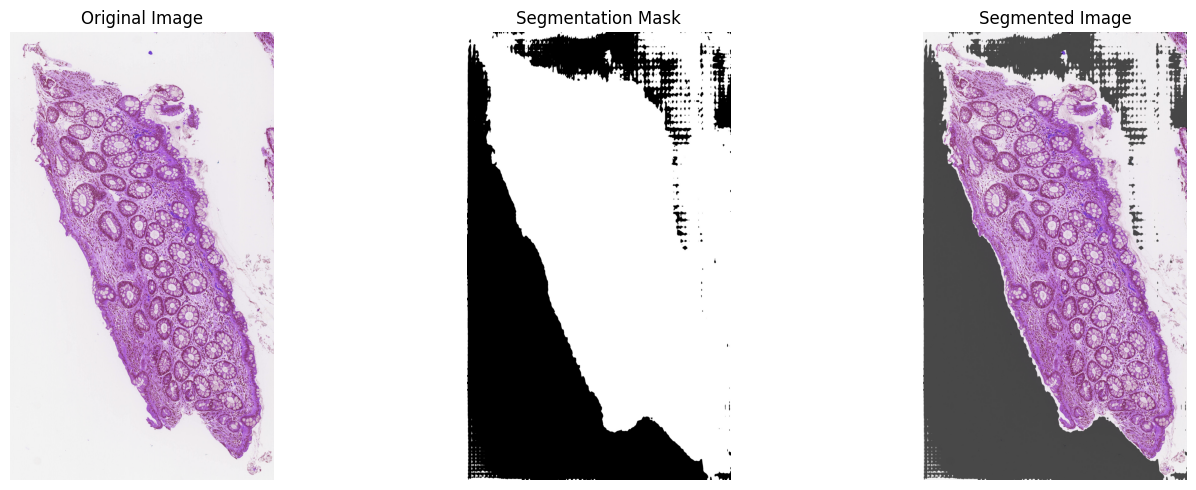

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import choice


    # Plot images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.imread("/content/content/content/mydata/tissue-train-neg/training/unmasked/1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096.jpg"))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(cv2.imread("/content/content/content/mydata/tissue-train-neg/training_masks/1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096.jpg"))
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")

axes[2].imshow(cv2.imread("/content/content/content/mydata/tissue-train-neg/training_masked/1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096.jpg"))
axes[2].set_title("Segmented Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
!zip -r /content/mydata_masked.zip /content/content/content/mydata
!mv /content/mydata_masked.zip /content/drive/MyDrive/

  adding: content/content/content/mydata/ (stored 0%)
  adding: content/content/content/mydata/tissue-train-neg/ (stored 0%)
  adding: content/content/content/mydata/tissue-train-neg/training/ (stored 0%)
  adding: content/content/content/mydata/tissue-train-neg/training/unmasked/ (stored 0%)
  adding: content/content/content/mydata/tissue-train-neg/training/unmasked/D20180723501_2019-06-10 13_47_37-lv1-5074-30454-4941-5296.jpg (deflated 2%)
  adding: content/content/content/mydata/tissue-train-neg/training/unmasked/2019-06-10 23_36_39-lv1-10151-9330-7307-5415.jpg (deflated 3%)
  adding: content/content/content/mydata/tissue-train-neg/training/unmasked/2019-11827-1-1-1_2019-05-28 14_14_04-lv1-38890-14353-5119-7083.jpg (deflated 1%)
  adding: content/content/content/mydata/tissue-train-neg/training/unmasked/D20180686301_2019-06-10 13_09_08-lv1-15727-16927-5566-6475.jpg (deflated 1%)
  adding: content/content/content/mydata/tissue-train-neg/training/unmasked/2019-06-11 00_58_36-lv1-820-6

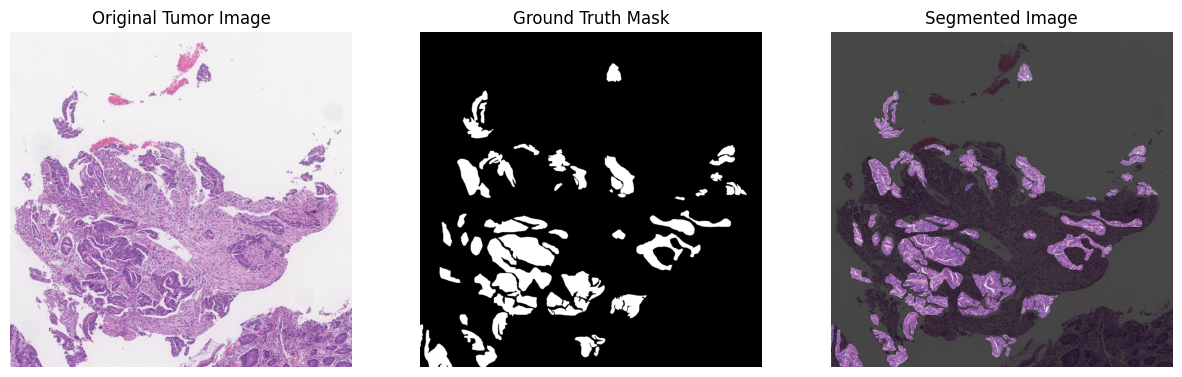

In [ ]:
#segmennting tumor images using ground truth masks
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#/content/mydata/tissue-train-pos-v1/training/18-02791B_2019-05-07 22_25_06-lv1-18872-21098-4813-3880.jpg
#/content/mydata/tissue-train-pos-v1/18-02791B_2019-05-07 22_25_06-lv1-20335-15924-3753-2862_mask.jpg
#/content/mydata/tissue-train-pos-v1/18-02791B_2019-05-07 22_25_06-lv1-14165-17366-6446-4855_mask.jpg
# Define paths
tumor_image_path = "/content/mydata/tissue-train-pos-v1/training/18-04842B_2019-05-07 23_40_49-lv1-25280-12651-4140-4061.jpg"  # Change to your image name
mask_image_path = tumor_image_path.replace(".jpg", "_mask.jpg")  # Assuming mask has same name with "_mask.jpg"
mask_image_path = mask_image_path.replace("/training/", "/")
# Load images
tumor_img = cv2.imread(tumor_image_path)
tumor_img = cv2.cvtColor(tumor_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization

mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

# Ensure mask and image have the same size
if mask.shape[:2] != tumor_img.shape[:2]:
    mask = cv2.resize(mask, (tumor_img.shape[1], tumor_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Convert mask to binary (threshold = 128)
_, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
binary_mask = binary_mask / 255.0  # Normalize to 0-1 range

# Apply mask: Keep tumor areas, dim non-tumor areas
dim_factor = 0.3
segmented_img = (tumor_img * binary_mask[..., np.newaxis]) + (tumor_img * dim_factor * (1 - binary_mask[..., np.newaxis]))
segmented_img = segmented_img.astype(np.uint8)

# Plot images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(tumor_img)
axes[0].set_title("Original Tumor Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(segmented_img)
axes[2].set_title("Segmented Image")
axes[2].axis("off")

plt.show()
